You can use this notebook to implement a recommendation system with Personalized PageRank. It applies the votes data to recommend a film based on what you like. You should run the "scrape" notebook if you have not scraped the data.

In [4]:
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import numpy as np
import json
import os.path
import sys
from tabulate import tabulate
import difflib

In [5]:
# List of films is saved in FILMS_PATH
# List of voters is saved in VOTERS_PATH
# List of voter-film pair is saved in VOTES_PATH 
FOLDER_PATH = 'data'
FILMS_PATH = '{}/films.json'.format(FOLDER_PATH)
VOTERS_PATH = '{}/voters.json'.format(FOLDER_PATH)
VOTES_PATH = '{}/votes.json'.format(FOLDER_PATH)

In [6]:
# Helper functions

# Load voters from VOTERS_PATH into a list
def load_voters():
    if not os.path.exists(VOTERS_PATH):
        raise RuntimeError('File not found in {}'.format(VOTERS_PATH))
    with open(VOTERS_PATH) as json_file:
        return json.load(json_file)

# Load films from FILMS_PATH into a list
def load_films():
    if not os.path.exists(FILMS_PATH):
        raise RuntimeError('File not found in {}'.format(FILMS_PATH))
    with open(FILMS_PATH) as json_file:
        return json.load(json_file)

# Load votes from VOTES_PATH into a numpy matrix
def load_votes():
    if not os.path.exists(VOTES_PATH):
        raise RuntimeError('File not found in {}'.format(VOTES_PATH))
    with open(VOTES_PATH) as json_file:
        votes_data = json.load(json_file)
    print('Loaded votes from {}'.format(VOTES_PATH))
    coord = np.array(votes_data).transpose()
    values = np.ones(len(votes_data))
    return coo_matrix((values, coord)).toarray()

# Print ramdon votes
def print_random_votes(vote_matrix, films, voters, n=1):
    [row_range, col_range] = vote_matrix.nonzero()
    for i in range(n):
        r = np.random.randint(0, len(row_range))
        print(films[col_range[r]]['name'])
        print(voters[row_range[r]]['name'])
        print(voters[row_range[r]]['url'])
        sys.stdout.flush()

# Print winners of the poll
def print_winners(vote_matrix, films, n=1):
    # Find the winners
    winners = np.argsort(-vote_matrix.sum(0))
    print('Winners are:')
    print(tabulate([[films[i]['name'], int(vote_matrix.sum(0)[i])] for i in winners[0:n]],\
                   headers=['name', 'votes']))

# Print voters who vote for more or less than 10 films
def print_irregular_voters(vote_matrix, voters):
    # Find the irregular voters who do not vote for 10 films
    print('These voters do not vote for 10 films')
    print(tabulate(
        [
            [voters[i]['name'], int(vote_matrix.sum(1)[i])] \
            for i in range(len(voters)) if vote_matrix.sum(1)[i] != 10 \
        ],\
        headers=['name', 'votes']
    ))

# Find index of a film based on its name
# Use optional year argument to distinguish films with the same name
def find_film_idx(films, film_name, year=None):
    film_name_lower = [f['name'].lower() for f in films]
    matches = difflib.get_close_matches(film_name.lower(), film_name_lower, 1)
    if len(matches) == 0:
        raise RuntimeError('Cannot find film named {}'.format(film_name))
    matches_idx = [i for i in range(len(films)) if film_name_lower[i] == matches[0]]
    if len(matches_idx) > 1 and year is not None:
        year_errors = [0 if films[i]['year'] is None else np.abs(year - films[i]['year']) for i in matches_idx]
        return matches_idx[year_errors.index(min(year_errors))]
    return matches_idx[0]

In [7]:
films = load_films()
voters = load_voters()
vote_matrix = load_votes()
vote_by_film = vote_matrix.sum(0)

Loaded votes from data/votes.json


## Preliminary Analysis
We look at a few basic characteristics of the votes. 

In [8]:
print_winners(vote_matrix, films, 10)

Winners are:
name                     votes
---------------------  -------
Vertigo                    222
Citizen Kane               199
Tokyo Story                155
2001: A Space Odyssey      132
Règle du jeu, La           117
Sunrise                    110
8½                         104
Searchers, The              89
Apocalypse Now              86
Breathless                  84


In [9]:
print_irregular_voters(vote_matrix, voters)

These voters do not vote for 10 films
name                 votes
-----------------  -------
Edna Fainaru             9
David O. Russell        11
Martin Scorsese         12
Quentin Tarantino       12


Top 20% of the films have 74.3% of the votes


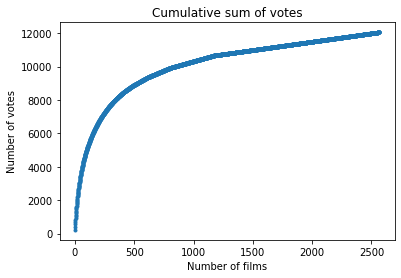

In [10]:
# Show cummulative sum of votes
vote_cumsum = np.cumsum(np.sort(vote_by_film)[::-1])
print('Top 20% of the films have {}% of the votes'.format(
    round(100 * vote_cumsum[int(len(films) * 0.2)] / vote_cumsum[-1], 1) \
))
plt.plot(vote_cumsum, marker='.')
plt.title('Cumulative sum of votes')
plt.xlabel('Number of films')
plt.ylabel('Number of votes')
plt.show()

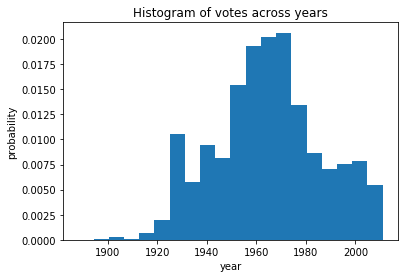

In [11]:
all_vote_years = []

for i in range(len(films)):
    if films[i]['year'] is not None:
        for j in range(len(voters)):
            if vote_matrix[j,i] > 0:
                all_vote_years.append(films[i]['year'])
                
plt.hist(all_vote_years, 20, density=True)
plt.title('Histogram of votes across years')
plt.xlabel('year')
plt.ylabel('probability')
plt.show()

In [13]:
# Compare the average year from same voter
vote_year = []
avg_other_year = []
for i in range(len(voters)):
    year_group = [
        films[j]['year'] \
        for j in range(len(films)) if vote_matrix[i,j] > 0 and films[j]['year'] is not None \
    ]
    if len(year_group) > 2:
        year_sum = np.sum(year_group)
        for y in year_group:
            vote_year.append(y)
            avg_other_year.append((year_sum - y) / (len(year_group) - 1))

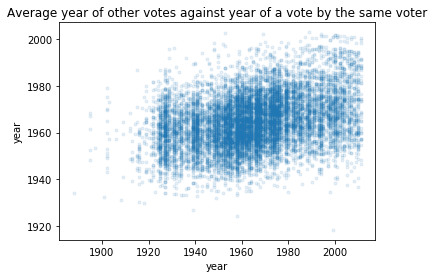

In [14]:
plt.scatter(vote_year, avg_other_year, marker='.', alpha=0.1)
plt.title('Average year of other votes against year of a vote by the same voter')
plt.axis('scaled')
plt.xlabel('year')
plt.ylabel('year')
plt.show()

In [15]:
print('Correlation is {}'.format(round(np.corrcoef(vote_year, avg_other_year)[0, 1], 2)))

Correlation is 0.33


## Recommendation with Personalized PageRank
The vote matrix can be modified to represent probabilities. We can divide each entry of the matrix by its row sum. The $(i,j)$ entry of the result is the probability film $j$ is choosen given voter $i$. If we divide the each entry of the vote matrix by its column sum, the $(i,j)$ entry of the result becomes the probabilty that a vote is casted by voter $i$ given that it is a vote on film $j$. These two matrix of conditional probability can be combined to calculate the probability that a voter choosing film $i$ given that the voter chooses film $j$.

The final result is a matrix of conditional probability. It is also a network representation of the relationship of the films.

In [16]:
prob_v_f = vote_matrix / vote_matrix.sum(0, keepdims=True) # P(voter i | film j)
prob_f_v = vote_matrix / vote_matrix.sum(1, keepdims=True) # P(film j | voter i)
prob_f_f = np.matmul(np.transpose(prob_f_v), prob_v_f) # P(flim i | film j)

We can apply Personalized PageRank to analyze the matrix of probabilities and generate recommendation.

Denote $P$ as the matrix where $P_{ij}$ is the probabilty a voter choosing film $i$ given film $j$ is choosen. Under the network interpretation of $P$, every film is a node in the network and $P_{ij}$ is the chance going film $i$ at film $j$.

Suppose a new voter appears with a preference $e$, where $e$ is a vector of probability of casting a vote to a film. We require the sum $e$ to equal 1.

We can use $P$ to expand the preference of the new voter. Knowing which film the new voter likes ($e$), we infer which films can also likely to be chosen with $Pe$. We can repeat this step to calculate $PPe$ to expand the preferences into more films.

The process can be interpreted as with a network. Starting at film (node) $j$ with probability $e_j$, the new voter follows the graph $P$ can travels to a new film (node) $i$ from node $j$ with probability $p_{ij}$. The new voters continues walking randomly from node to node. The chance that the new voter landing on node $j$ on step $k$ is $(P^ke)_{j}$.

We let the random walk contniues indefinitely and measure the chance a voter landing on a film. The problem however is that the starting probability $e$ has lower influence after each step. The voter travelling the graph will eventually become the same as any other voter and pick the winners in the poll. Keeping the personal preference in mind, the new voter at every step has a small chance of restrating by choosing a film (node) using $e$. Let $\alpha$ be the chance that a voter keeps walking on the graph. The chance of restarting at each step is $1-\alpha$. Let $x_k$ be bhe probability of the voter on each nodes on step $k$.
$$x_k = \alpha Px_{k - 1}+(1-\alpha)e, x_0 = e.$$
With infinite iterations, we expect $x_k$ and $x_{k-1}$ to converge to the same vector. Denote the converged probability to be $x^*$. It can be calculated with the formula
$$ x^*= (1-\alpha)(I - \alpha P)^{-1}e.$$

Solving $x^*$ analytically is possible in our case because $P$ is a small matrix. Otherwise, specialized iterative algorithm is used to approximate $x^*$.

In [17]:
alpha = 0.85
prob_sol = (1 - alpha) * np.linalg.inv(-alpha * prob_f_f + np.identity(len(films)))
recommend = lambda e, n=1 : np.argsort(-prob_sol.dot(e))[0:n]

In [18]:
# Compare the average year of recommendation
valid_year = []
weighted_recommend_year = []
for i in range(len(films)):
    if films[i]['year'] is not None:
        sum_p = 0
        p_year_dot_prod = 0
        valid_year.append(films[i]['year'])
        for j in range(len(films)):
            if j != i and films[j]['year'] is not None:
                sum_p += prob_sol[j, i]
                p_year_dot_prod += prob_sol[j, i] * films[j]['year']
        if sum_p == 0:
            raise RuntimeError('sum_p equals zero for film {}'.format(i))
        weighted_recommend_year.append(p_year_dot_prod / sum_p)

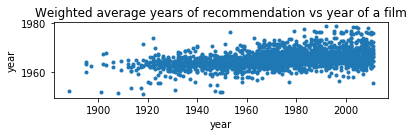

In [19]:
plt.scatter(valid_year, weighted_recommend_year, marker='.')
plt.axis('scaled')
plt.title('Weighted average years of recommendation vs year of a film')
plt.xlabel('year')
plt.ylabel('year')
plt.show()

In [20]:
print('Correlation is {}'.format(round(np.corrcoef(valid_year, weighted_recommend_year)[0, 1], 2)))

Correlation is 0.43


The recommendation preserves the year correlation in the voters' choices.

In [21]:
film_idx = np.random.randint(0, len(films))
e = np.zeros(len(films))
e[film_idx] = 1
print('Recommendation for if you like "{}"'.format(films[film_idx]['name']))
print(tabulate(
    [
        [films[r_idx]['name'], prob_sol[r_idx, film_idx]] \
         for r_idx in recommend(e, 11) if r_idx != film_idx \
    ], \
    headers=['name', 'prob']) \
)

Recommendation for if you like "Last Tango in Paris"
name                          prob
-----------------------  ---------
Leopard, The             0.0148398
Wild Bunch, The          0.0145509
Trade Tattoo             0.0135907
WALL-E                   0.0135436
Zorns Lemma              0.013534
Godfather: Part I, The   0.0135226
Vertigo                  0.0129302
Outlaw Josey Wales, The  0.0127257
Get Carter               0.0120538
Roman Holiday            0.0120538


In [22]:
avg_e = np.full(len(films), 1./ len(films))
avg_prob = prob_sol.dot(avg_e)
print('Recommendation for if you like every film equally'.format(films[film_idx]['name']))
print(tabulate(
    [[films[film_idx]['name'], avg_prob[film_idx]] for film_idx in recommend(avg_e, 10)], \
    headers=['name', 'prob']) \
)

Recommendation for if you like every film equally
name                           prob
-----------------------  ----------
Vertigo                  0.0136717
Citizen Kane             0.0118259
Tokyo Story              0.00959687
2001: A Space Odyssey    0.00818122
Règle du jeu, La         0.00701646
Sunrise                  0.00686432
8½                       0.00621959
Searchers, The           0.00551749
Man with a Movie Camera  0.00546204
Apocalypse Now           0.00536394


The recommendation based on Personalized PageRank frequently intersects with films with the highest ranking in the poll. This is expected because these are the films frequently choosen by voters on average. We can measure the difference between recommendation based on a user's choice against the avarege recommendation. It reveals which films are especially more likely to be chosen beacuse of the idiosyncrasy in a voter's choice.

In [23]:
avg_e = np.full(len(films), 1./ len(films))
avg_prob = prob_sol.dot(avg_e)
def recommend_special(e, n=1):
    special_prob = prob_sol.dot(e)
    # Difference measured with probability weighted log-likelihood ratio
    return np.argsort(special_prob*np.log(avg_prob/special_prob))[0:n]

In [24]:
# Write your favorite film's name
favorite_film_name = 'Leclisse' 
# Optionally, write your favorite film's year if to distinguish films with the same name 
favorite_film_year = None 
print('Your favorite film is {}{}'.format(
    favorite_film_name, \
    '' if favorite_film_year is None else '({})'.format(favorite_film_year) \
))

Your favorite film is Leclisse


In [26]:
film_idx = find_film_idx(films, favorite_film_name, favorite_film_year)
e = np.zeros(len(films))
e[film_idx] = 1
print('Recommendation for if you like "{}"'.format(films[film_idx]['name']))
print(tabulate(
    [
        [films[r_idx]['name'], films[r_idx]['year'], prob_sol[r_idx, film_idx]] \
         for r_idx in recommend(e, 11) if r_idx != film_idx \
    ], \
    headers=['name', 'year', 'prob']) \
)
print('\nSpeical recommendation for if you like "{}"'.format(films[film_idx]['name']))
print(tabulate(
    [
        [films[r_idx]['name'], films[r_idx]['year'], prob_sol[r_idx, film_idx]] \
        for r_idx in recommend_special(e, 11) if r_idx != film_idx \
    ], \
    headers=['name', 'year', 'prob']) \
)

Recommendation for if you like "eclisse, L'"
name                     year        prob
---------------------  ------  ----------
Vertigo                  1958  0.0154938
Citizen Kane             1941  0.0135448
Tokyo Story              1953  0.0110944
Règle du jeu, La         1939  0.0110109
8½                       1963  0.00821841
Sunrise                  1927  0.00814934
Mirror                   1974  0.00813281
2001: A Space Odyssey    1968  0.00803613
Atalante, L'             1934  0.00754223
Andrei Rublev            1966  0.00690603

Speical recommendation for if you like "eclisse, L'"
name                           year        prob
---------------------------  ------  ----------
Règle du jeu, La               1939  0.0110109
Mirror                         1974  0.00813281
Andrei Rublev                  1966  0.00690603
Atalante, L'                   1934  0.00754223
Colour of Pomegranates, The    1968  0.00338033
8½                             1963  0.00821841
Diary of a Country